## DS520 Final Project- SkinCancer Detection using XceptionNet Model

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Load GroundTruth.csv
ground_truth_path = '/content/drive/My Drive/archive (1)/GroundTruth.csv'

In [5]:
image_dir = '/content/drive/My Drive/imagesnew'

In [6]:
ground_truth = pd.read_csv(ground_truth_path)

In [7]:
# Extract image names and labels
image_names = ground_truth['image'].values
labels = ground_truth.drop(columns=['image']).values

In [8]:
print("Number of images:", len(image_names))
print("Number of labels:", labels.shape)

Number of images: 10015
Number of labels: (10015, 7)


In [9]:
# Use 1/4 th of the dataset
num_samples = len(image_names)
samples = num_samples // 4

In [10]:
# Subset of data
image_names_subset = image_names[:half_samples]
labels_subset = labels[:half_samples]

In [11]:
samples

2503

In [12]:
# Load images
images = []
for image_name in image_names_subset:
    image_path = os.path.join(image_dir, image_name + '.jpg')
    img = cv2.imread(image_path)
    if img is not None:
        img = cv2.resize(img, (224, 224))  # Resize to match the input size
        images.append(img)


In [13]:
# Convert images and labels to NumPy arrays
images = np.array(images)
labels = np.array(labels)

In [14]:
print("Images shape:", images.shape)
print("Labels shape:", labels_subset.shape)

Images shape: (2503, 224, 224, 3)
Labels shape: (2503, 7)


In [15]:
# Visualize class distribution
class_names = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
class_counts = labels.sum(axis=0)

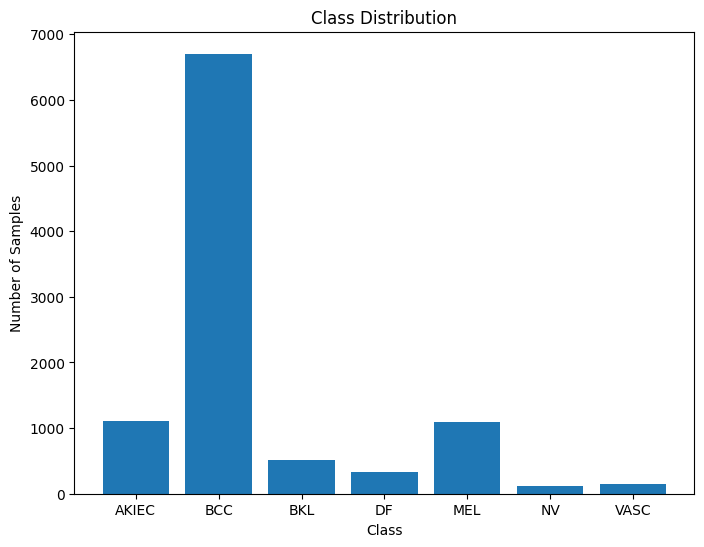

In [16]:
plt.figure(figsize=(8, 6))
plt.bar(class_names, class_counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

In [17]:
# Split dataset into training, validation, and test sets
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels_subset, test_size=0.2, stratify=labels_subset, random_state=42
)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

In [18]:
print("Train images shape:", train_images.shape)
print("Validation images shape:", val_images.shape)
print("Test images shape:", test_images.shape)


Train images shape: (1601, 224, 224, 3)
Validation images shape: (401, 224, 224, 3)
Test images shape: (501, 224, 224, 3)


In [19]:
# Normalize pixel values
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

In [20]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


In [21]:
# Build XceptionNet model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(labels.shape[1], activation='softmax')(x)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [22]:
model = Model(inputs=base_model.input, outputs=predictions)


In [23]:

# Freeze base layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

In [24]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
callbacks = [
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-4, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]


In [26]:
# Train the model
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=16),
    validation_data=(val_images, val_labels),
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.6497 - loss: 1.2350
Epoch 1: val_accuracy improved from -inf to 0.68579, saving model to best_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 63s 471ms/step - accuracy: 0.6499 - loss: 1.2337 - val_accuracy: 0.6858 - val_loss: 0.9462 - learning_rate: 0.0010
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6635 - loss: 1.0163
Epoch 2: val_accuracy improved from 0.68579 to 0.68828, saving model to best_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 22s 208ms/step - accuracy: 0.6638 - loss: 1.0157 - val_accuracy: 0.6883 - val_loss: 0.9399 - learning_rate: 0.0010
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.6916 - loss: 0.9157
Epoch 3: val_accuracy improved from 0.68828 to 0.70075, saving model to best_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 43s 226ms/step - accuracy: 0.6916 - loss: 0.9158 - val_accuracy: 0.7007 - val_loss: 0.8802 - learning_rate: 0.0010
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/st

In [27]:
# Unfreeze some layers and fine-tune
for layer in base_model.layers[-10:]:  # Unfreeze last 10 layers for fine-tuning
    layer.trainable = True

In [28]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [29]:
history_fine_tune = model.fit(
    datagen.flow(train_images, train_labels, batch_size=16),
    validation_data=(val_images, val_labels),
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.6751 - loss: 1.0777
Epoch 1: val_accuracy did not improve from 0.75561
101/101 ━━━━━━━━━━━━━━━━━━━━ 42s 300ms/step - accuracy: 0.6752 - loss: 1.0773 - val_accuracy: 0.6983 - val_loss: 1.3357 - learning_rate: 0.0010
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7264 - loss: 0.8131
Epoch 2: val_accuracy did not improve from 0.75561
101/101 ━━━━━━━━━━━━━━━━━━━━ 26s 203ms/step - accuracy: 0.7263 - loss: 0.8133 - val_accuracy: 0.7182 - val_loss: 0.9054 - learning_rate: 0.0010
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7386 - loss: 0.7875
Epoch 3: val_accuracy did not improve from 0.75561
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 203ms/step - accuracy: 0.7385 - loss: 0.7876 - val_accuracy: 0.7257 - val_loss: 1.1003 - learning_rate: 0.0010
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.7457 - loss: 0.7272
Epoch 4: val_accuracy did not improve from 0.75561
101/101 ━━━━

In [30]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 540ms/step - accuracy: 0.6794 - loss: 1.0451
Test Accuracy: 0.6846


In [31]:
# Generate predictions
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step


In [32]:
# Classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

       AKIEC       0.54      0.31      0.39        42
         BCC       0.87      0.83      0.85       345
         BKL       0.18      0.83      0.30        24
          DF       0.50      0.05      0.10        19
         MEL       0.80      0.28      0.42        57
          NV       0.00      0.00      0.00         6
        VASC       0.40      0.75      0.52         8

    accuracy                           0.68       501
   macro avg       0.47      0.44      0.37       501
weighted avg       0.77      0.68      0.69       501



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 13  20   8   0   1   0   0]
 [  5 287  46   0   0   0   7]
 [  0   3  20   0   1   0   0]
 [  1   0  16   1   1   0   0]
 [  4  19  15   1  16   0   2]
 [  0   2   3   0   1   0   0]
 [  1   0   1   0   0   0   6]]


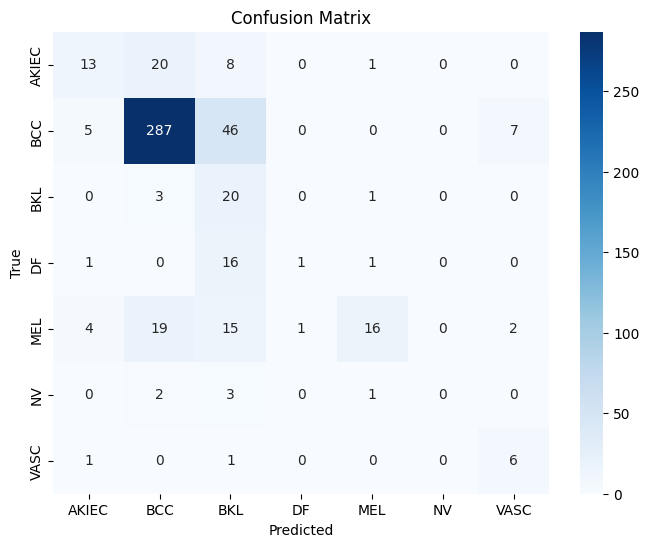

In [34]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

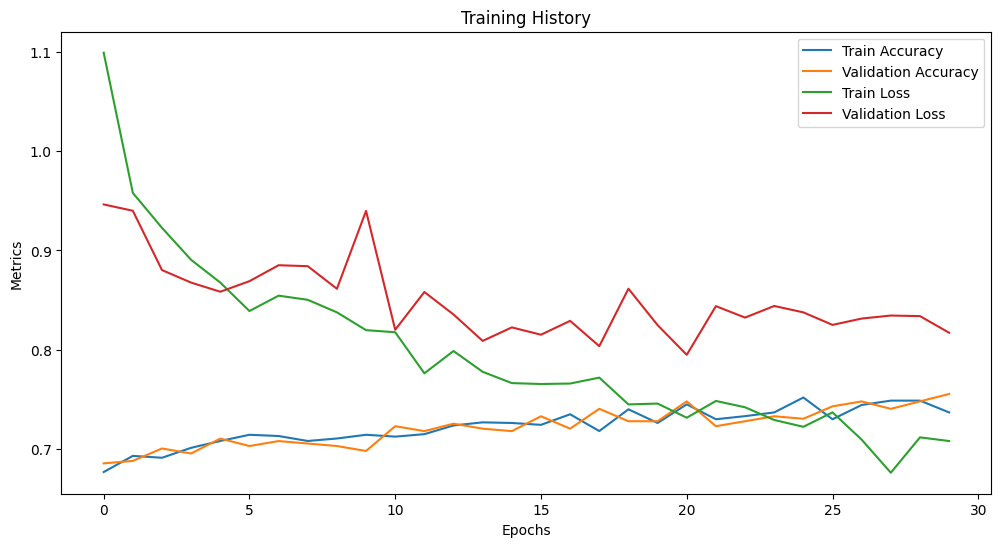

In [35]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.title('Training History')
plt.show()